# One Max Problem

##### One Max Problem — DEAP 1.3.1 documentation. (2020). Retrieved 11 August 2020, from https://deap.readthedocs.io/en/master/examples/ga_onemax.html

Utilizaremos la librería de Python DEAP que es un framework de cómputo evolutivo para hacer prototipos rápidamente y probar ideas. Busca hacer algoritmos explícitos y estructuras de datos transparentes. Trabaja en perfecta armonía con mecanismos de paralelismo como `multiprocessing` y `SCOOP`.

## Ejemplo que maximiza la suma de una lista de enteros.

Por ejemplo se comienza con un conjunto de listas de 0s y 1s aleatorios (e.g. [0,1,0,0,0]), y se busca evolucionar hasta que algún elemento llegue a ser de la forma [1,1,1,1,1].

Hay muchos parámetros que se pueden ajustar como la logitud de las listas, el tamaño inicial de la población, etc.

El problema a resolver ayuda a entender algunas de las posibilidades de este framework e ilustra de manera concisa el concepto de máquinas evolutivas en general. Primero importaremos los módulos necesarios



In [1]:
import random

from deap import base
from deap import creator
from deap import tools

## Creator 

Debido a que la estructura exacta de los individuos en los algoritmos genéticos depende fuertemente en la problema que se quiere resolver, DEAP no tiene una estructura explícita. Lo que si hace es darnos una manera conveniente para crear "contenedores" de atributos, asociarlos con su aptitud (fitness) llamado $\texttt{deap.creator}$. 

$\texttt{creator}$ es una fábrica de clases que las va generando durante el tiempo de ejecución. El primer argumento es el nombre de la clase, seguido de la clase base de la cual heredará, y finalmente cualquier argumento que queramos pasar a la hora de instanciar la misma.

In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

## Toolbox

Utilizaremos la clase a la medida que acamos de crear y haremos uso de Toolbox para crear a nuestro individuos así como a toda la población.

Herramientas para crear a los individuos ($\texttt{random.randint}$), los individuos mismos y la población, quedará registarada bajo un contenedor llamado $\texttt{Toolbox}$. Tiene dos métodos para agregar o remover contenido, register() y unregister().

Es importante mencionar que de forma análoga a $\texttt{creator.create}$, el primer argumento es el nombre de nuestra función, luego la función que encapsula y finalmente los argumentos de la función. Al registrar las herramientas en el toolbox, solamente crea alias a la funciones ya existentes y congela parte de sus argumentos. Con esto podemos dejar algunos de los argumentos abiertos para modificarlos después. Por ejemplo, en el caso de la población.

In [3]:
toolbox = base.Toolbox()

# Generador de atributos 
#                      'attr_bool' es un atributo ('gen')
#                      que corresponde a enteros uniformemente muestreados
#                      del rango [0,1] (i.e. 0 o 1 con igual
#                      probabilidad)
toolbox.register("attr_bool", random.randint, 0, 1)

# Inicializador de estructura
#                         define 'individuo' como uno consistiendo 
#                         de 50 elementos 'attr_bool' ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 50)

# Define la población como un conjunto de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# La funcion objetivo ('fitness') a maximizar
def evalOneMax(individual):
    return sum(individual),

#----------
# Registro de operaciones
#----------
# Registra el objetivo / fitness
toolbox.register("evaluate", evalOneMax)

# Registra el operador de cruza
toolbox.register("mate", tools.cxTwoPoint)

# Registra el operador de mutación que cambia cada
# atributo/gen con probabilidad of 0.0555
toolbox.register("mutate", tools.mutFlipBit, indpb=0.0555)

# operador para seleccionar individuos por el método de la ruleta
# donde cada elemento de la nueva generación se sustituye por 
# otro de la población total. La probabilidad de obtener un 1
# está dada por la suma de todos los 1s entre el total. 
# Evidentemente lo mismo para el 0. 
toolbox.register("select", tools.selTournament,fit_attr='fitness',tournsize=3)

#----------


## Evolucionando la población

Una vez que se eligen los operadores genéticos, vamos a definir un algoritmo que combine todas las partes individuales y que realice la evolución de nuestra población hasta que el problema de maximización de un parámetro se resuelva. Por convención, esto se hará dentro de una función llamada $\texttt{main()}$.

In [4]:
import logging
import timeit
# Cambia logging.INFO para obtener menos verborrea
# Cambia logging.WARNING para silenciar por completo
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
def main(
    poblacion_inicial: int = 50,
    tamaño_individuo: int = 30,
    prob_cruza: float = 0.7,
    prob_mutación: float = 0.0555,
    max_iter: int = 1000,
):
    random.seed()

    # Decidí registrar al individuo y a la población aquí
    # para poder invocar la función main con todos los
    # argumentos sin tener que ir más arriba a redefinir valores
    toolbox.register(
        "individual",
        tools.initRepeat,
        creator.Individual,
        toolbox.attr_bool,
        tamaño_individuo,
    )

    # Se define la población como un conjunto de n=poblacion_inicial listas
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # Crea una población inicial de n individuos
    # (cada uno es una lista de 0s y 1s)
    pop = toolbox.population(n=poblacion_inicial)

    # CXPB  es la probabilidad de cruza
    #
    #
    # MUTPB es la probabilidad de mutación
    CXPB, MUTPB = prob_cruza, prob_mutación

    logging.debug("Start of evolution")

    # Se evalua la aptitud (fitness) de la población entera 
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    logging.debug("  Evaluated %i individuals" % len(pop))

    # Se extrae la aptitud (fitness)
    fits = [ind.fitness.values[0] for ind in pop]

    # Esta variable guarda el número de generaciones    
    g = 0

    # Comienza la evolución
    while max(fits) < tamaño_individuo and g < max_iter:
        # Una nueva generación
        g = g + 1
        logging.debug("-- Generation %i --" % g)

        # Selecciona la nueva generación de individuos
        offspring = toolbox.select(pop, len(pop))
        # Clona los individuos seleccionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplica la cruza y mutación
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cruza a dos individuos con probabilidad CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # aptitudes de los hijos
                # deben ser recalculados
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # muta con probabilidad MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evalua a los individuos con una aptitud inválida
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        logging.debug("  Evaluated %i individuals" % len(invalid_ind))

        # La población es reemplazada por los hijos
        pop[:] = offspring

        # Junta todas las aptitudes en una lista e imprime estadísticas
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5

        logging.debug("  Min %s" % min(fits))
        logging.debug("  Max %s" % max(fits))
        logging.debug("  Avg %s" % mean)
        logging.debug("  Std %s" % std)

    logging.debug("------------- Fin de la evolución actual--------------")

    best_ind = tools.selBest(pop, 1)[0]
    logging.info("Número de generaciones %s" % g)
    logging.info("El mejor individuo es %s, %s" % (best_ind, best_ind.fitness.values))
    return g





In [5]:
if __name__ == "__main__":
    main()

# Ejemplo explícito de lo que se está logrando con este algoritmo

Profesor, para no tratar de llenar con muchos datos el resultado obtenido, decidí silenciar la salida de datos. Las gráficas de hasta abajo simplemente son 100 corridas del algoritmo con diferentes configuraciones de probabilidad de mutación, tamaño de los individuos, tipo de algoritmo de selección, etc. 

Lo unico que cambié fue `logger.setLevel(logging.DEBUG)` para mostrar las evoluciones generación a generación para de una de esas 100 corridas.

# Aleatoridad y tiempo de cómputo - Torneo
 
A continuación veremos como el número de generaciones es proporcional al tiempo de cómputo. El resultado es bastante intuitivo, entre más generaciones tardamos en llegar a la lista de 1s, mayor es el tiempo de procesamiento

In [7]:
# Funcion para almacenar el número de generaciones y el tiempo de ejecución
import io
from contextlib import redirect_stdout


def generaciones_y_tiempo(
    poblacion_inicial: int = 50,
    tamaño_individuo: int = 30,
    prob_cruza: float = 0.7,
    prob_mutación: float = 0.0555,
    max_iter: int =1000):
    f = io.StringIO()
    with redirect_stdout(f):
        print(
            timeit.timeit(
                f"print(main(poblacion_inicial={poblacion_inicial} ,tamaño_individuo={tamaño_individuo} ,prob_cruza={prob_cruza},prob_mutación={prob_mutación},max_iter={max_iter}))",
                number=1,
                globals=globals(),
            )
        )
    out = f.getvalue()
    return list(out.split("\n")[:-1])


# Vamos a hacer 100 simulaciones independientes, donde llegaremos al número requerido de 30 unos e imprimiermos todo a pantalla para mostrar que efectivamente se llega al resultado.  

## Cada simulación termina al llegar al siguiente estado
```
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 14
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
```

In [8]:
logger.setLevel(logging.DEBUG)
datos_tarea=[generaciones_y_tiempo() for i in range(100)]

DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 13.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 17.52
DEBUG:root:  Std 2.256014184352576
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 19.44
DEBUG:root:  Std 2.0606794995825997
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 21.22
DEBUG:root:  Std 1.55293270942434
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 17.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.32
DEBUG:root:  Std 1.6424372134118144
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 23.62
DEBUG:root:  Std 1.1643023662262226
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root: 

DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 26.0
DEBUG:root:  Std 0.28284271247469134
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.04
DEBUG:root:  Std 0.5642694391866326
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.22
DEBUG:root:  Std 0.6415605972938342
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.74
DEBUG:root:  Std 0.6264183905346857
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.14
DEBUG:root:  Std 0.5660388679233517
DEBUG:root:-- Generation 15 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.4
DEBUG:root:  Std 0.6633249580712068


DEBUG:root:  Std 0.41761226035641175
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 29.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 29.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 15 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.96
DEBUG:root:  Std 0.19595917942271598
DEBUG:root:-- Generation 16 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 17 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 29.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 29.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 18 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 29.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 29.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 19 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.98
DEBUG:root:  S

DEBUG:root:  Avg 27.88
DEBUG:root:  Std 0.515363949068956
DEBUG:root:-- Generation 25 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.78
DEBUG:root:  Std 0.9228217596047257
DEBUG:root:-- Generation 26 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.96
DEBUG:root:  Std 0.1959591794224259
DEBUG:root:-- Generation 27 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.96
DEBUG:root:  Std 0.2799999999999782
DEBUG:root:-- Generation 28 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.92
DEBUG:root:  Std 0.27129319932490414
DEBUG:root:-- Generation 29 --
DEBUG:root:  Evaluated 45 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.96
DEBUG:root:  Std 0.2799999999999782
DEBUG:root:-- Generation 30 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root: 

DEBUG:root:  Avg 29.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 36 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 37 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.82
DEBUG:root:  Std 0.6539113089708604
DEBUG:root:-- Generation 38 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.41999999999993354
DEBUG:root:-- Generation 39 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.2374868417406312
DEBUG:root:-- Generation 40 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 41 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 24.0
DEBU

DEBUG:root:-- Generation 84 --
DEBUG:root:  Evaluated 44 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 85 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 86 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.2441311123145351
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 86
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 12.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 16.12
DEBUG:root:  Std 2.3292917378464892
DEBUG:roo

DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 21 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.76
DEBUG:root:  Std 1.030727898137967
DEBUG:root:-- Generation 22 --
DEBUG:root:  Evaluated 30 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.96
DEBUG:root:  Std 0.2799999999999782
DEBUG:root:-- Generation 23 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.6931089380465609
DEBUG:root:-- Generation 24 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 28.82
DEBUG:root:  Std 0.6225752966509516
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 24
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 24.32
DEBUG:root:  Std 1.0851727973000356
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 25.26
DEBUG:root:  Std 0.8199999999999543
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 25.66
DEBUG:root:  Std 1.0697663296253153
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 26.44
DEBUG:root:  Std 0.8754427451295579
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.12
DEBUG:root:  Std 0.9303762679690256
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 30 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.72
DEBUG:root:  Std 0.8726969691708824
D

DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 20 --
DEBUG:root:  Evaluated 46 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 21 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 22 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.84
DEBUG:root:  Std 0.5782732917921017
DEBUG:root:-- Generation 23 --
DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.92
DEBUG:root:  Std 0.43999999999981027
DEBUG:root:-- Generation 24 --
DEBUG:root:  Evaluated 43 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.84
DEBUG:root:  Std 0.7031358332499074
DEBUG:root:-- Generation 25 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root

DEBUG:root:  Evaluated 33 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.48
DEBUG:root:  Std 1.2367699866992081
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.44
DEBUG:root:  Std 0.8979977728257124
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.0
DEBUG:root:  Std 0.6324555320336579
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.3
DEBUG:root:  Std 0.7549834435271081
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.7
DEBUG:root:  Std 0.7000000000000065
DEBUG:root:-- Generation 15 --
DEBUG:root:  Evaluated 29 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.8
DEBUG:root:  Std 0.8485281374238061
DEB

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

DEBUG:root:-- Generation 95 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 96 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.88
DEBUG:root:  Std 0.47497368348150176
DEBUG:root:-- Generation 97 --
DEBUG:root:  Evaluated 27 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 98 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.84
DEBUG:root:  Std 0.64

DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 11.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 18.04
DEBUG:root:  Std 2.0876781361119865
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 19.52
DEBUG:root:  Std 1.699882348870071
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 17.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 20.7
DEBUG:root:  Std 1.4317821063276592
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 21.74
DEBUG:root:  Std 1.073498952025598
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.44
DEBUG:root:  Std 1.1516944039110033
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 23.16
DEBUG:root:  

DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 14.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 17.72
DEBUG:root:  Std 2.1075103795711305
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 16.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 19.36
DEBUG:root:  Std 2.066494616494317
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 16.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 20.96
DEBUG:root:  Std 1.9693653800145727
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 33 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.96
DEBUG:root:  Std 1.4416657032752038
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 31 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 24.1
DEBUG:root:  Std 0.9433981132056531
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 24.84
DEBUG:root:  Std 1.0461357464497922
DEBUG:

DEBUG:root:  Avg 19.72
DEBUG:root:  Std 1.6497272501841267
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 17.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 20.96
DEBUG:root:  Std 1.4136477637657645
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 21.98
DEBUG:root:  Std 0.8364209466530447
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 22.66
DEBUG:root:  Std 0.586856030044903
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.92
DEBUG:root:  Std 0.7440430095095043
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 23.24
DEBUG:root:  Std 0.8616263691415722
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 23

DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 19.86
DEBUG:root:  Std 2.0000999975001283
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 21.22
DEBUG:root:  Std 1.315902731967684
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.2
DEBUG:root:  Std 0.9591663046625523
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 22.94
DEBUG:root:  Std 0.903548559846083
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 23.56
DEBUG:root:  Std 0.8039900496897242
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 24.02
DEBUG:root:  Std 0.8364209466530786
DEBUG:r

DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.18
DEBUG:root:  Std 1.2440257232067142
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 22.98
DEBUG:root:  Std 1.4489996549343604
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 30 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 23.84
DEBUG:root:  Std 1.2547509713086373
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 24.76
DEBUG:root:  Std 1.1926441212700145
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 26 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 25.92
DEBUG:root:  Std 1.0166612021710404
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.72
DEBUG:roo

DEBUG:root:  Std 0.9797958971132318
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.34
DEBUG:root:  Std 0.9718024490604936
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.0
DEBUG:root:  Std 0.8944271909998904
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.72
DEBUG:root:  Std 0.8494704232638594
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.0
DEBUG:root:  Std 1.019803902718539
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.46
DEBUG:root:  Std 0.6069596362197007
DEBUG:root:-- Generation 15 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max

DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.92
DEBUG:root:  Std 0.559999999999855
DEBUG:root:-- Generation 41 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 28.8
DEBUG:root:  Std 0.8246211251235018
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 41
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 12.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 18.4
DEBUG:root:  Std 2.332380757938132
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 17.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 20.22
DEBUG:root:  Std 1.7353962083628176
DEBUG:root:-- Generation 3 --
DEBUG:root:  Eval

DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 19
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 14.0
DEBUG:root:  Max 21.0
DEBUG:root:  Avg 17.78
DEBUG:root:  Std 1.5911002482558945
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 19.2
DEBUG:root:  Std 2.0
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 20.74
DEBUG:root:  Std 1.706575518399361
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 25 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 21.96
DEBUG:root:  Std 1.5994999218505606
DEBUG:root:-- Generation 5 --
D

DEBUG:root:  Std 1.229796731171439
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.3
DEBUG:root:  Std 0.9219544457292395
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 26.78
DEBUG:root:  Std 0.8784076502399298
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.44
DEBUG:root:  Std 0.8979977728257124
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.94
DEBUG:root:  Std 0.8811356308763443
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.34
DEBUG:root:  Std 0.6200000000000224
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 

DEBUG:root:  Evaluated 43 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.6327716807822475
DEBUG:root:-- Generation 31 --
DEBUG:root:  Evaluated 44 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.41999999999993354
DEBUG:root:-- Generation 32 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.84
DEBUG:root:  Std 0.6437390775772437
DEBUG:root:-- Generation 33 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 13.0
DEBUG:ro

DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.72
DEBUG:root:  Std 0.7222188034107357
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.94
DEBUG:root:  Std 0.9254188241006848
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 33 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.22
DEBUG:root:  Std 0.7820485918407287
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.52
DEBUG:root:  Std 0.8772684879784344
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.2374868417406312
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.88
DEBUG:root:  Std 0.711055553385218


DEBUG:root:  Max 26.0
DEBUG:root:  Avg 22.44
DEBUG:root:  Std 1.6019987515600411
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 23.56
DEBUG:root:  Std 1.1516944039110528
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 24.58
DEBUG:root:  Std 1.0409610943738707
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 25.24
DEBUG:root:  Std 0.8380930735903532
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 31 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 25.78
DEBUG:root:  Std 0.8316249154515997
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.36
DEBUG:root:  Std 0.5919459434779801
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 41 individ

DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 19.48
DEBUG:root:  Std 1.602997192761104
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 20.66
DEBUG:root:  Std 0.9718024490604936
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 21.1
DEBUG:root:  Std 1.0246950765959377
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 22.04
DEBUG:root:  Std 1.1128342194594902
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 22.84
DEBUG:root:  Std 1.205985074534492
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 22 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 24.0
DEBUG:root:  Std 1.131370849898464
DEBUG:roo

DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.84
DEBUG:root:  Std 0.6437390775772437
DEBUG:root:-- Generation 30 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.9
DEBUG:root:  Std 0.4123105625618543
DEBUG:root:-- Generation 31 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 32 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.82
DEBUG:root:  Std 0.6539113089708604
DEBUG:root:-- Generation 33 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.5660388679234521
DEBUG:root:-- Generation 34 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.96
DEBUG:root:  Std 0.19595917942271598
DEBUG:root:-- Generation 35 --
DEBUG

DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.02
DEBUG:root:  Std 0.6779380502671487
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.5
DEBUG:root:  Std 0.6082762530298257
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.84
DEBUG:root:  Std 0.5425863986500178
DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 33 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.92
DEBUG:root:  Std 0.7440430095095043
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.1
DEBUG:root:  Std 1.0049875621120279
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 26 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.6
DEBUG:ro

DEBUG:root:  Min 16.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 19.24
DEBUG:root:  Std 1.6316862443497058
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 16.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 20.66
DEBUG:root:  Std 1.5180250327316698
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 22.0
DEBUG:root:  Std 1.428285685708577
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 23.1
DEBUG:root:  Std 1.1000000000000165
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 23.84
DEBUG:root:  Std 1.0071742649611453
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 24.58
DEBUG:root:  Std 1.0409610943738707
DEBUG:root:-- Generation 8 --
DEBUG:root:  Ev

DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 34 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.92
DEBUG:root:  Std 0.39191835884514187
DEBUG:root:-- Generation 35 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.88
DEBUG:root:  Std 0.47497368348150176
DEBUG:root:-- Generation 36 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 28.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 37 --
DEBUG:root:  Evaluated 30 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 28.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 38 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.88
DEBUG:root:  Std 0.4308131845707861
DEBUG:root:-- Generation 39 --
DEBUG:root:  Evaluated 39 individua

DEBUG:root:-- Generation 12 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.58
DEBUG:root:  Std 0.8022468448052583
DEBUG:root:-- Generation 13 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.96
DEBUG:root:  Std 0.2799999999999782
DEBUG:root:-- Generation 14 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.96
DEBUG:root:  Std 0.3440930106816345
DEBUG:root:-- Generation 15 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.04
DEBUG:root:  Std 0.5276362383309483
DEBUG:root:-- Generation 16 --
DEBUG:root:  Evaluated 23 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.34
DEBUG:root:  Std 0.586856030044903
DEBUG:root:-- Generation 17 --
DEBUG:root:  Evaluated 30 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.72
DEBUG

INFO:root:Número de generaciones 13
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 14.0
DEBUG:root:  Max 21.0
DEBUG:root:  Avg 17.66
DEBUG:root:  Std 1.4506550244630865
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 16.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 19.14
DEBUG:root:  Std 1.3268006632497604
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 29 individuals
DEBUG:root:  Min 16.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 20.04
DEBUG:root:  Std 1.4691494137765664
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 17.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 21.4
DEBUG:root:  Std 1.232882800593834
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  M

DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 25.74
DEBUG:root:  Std 1.0919706955775572
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 28.0
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

DEBUG:root:-- Generation 30 --
DEBUG:root:  Evaluated 33 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.5295280917949359
DEBUG:root:-- Generation 31 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.72
DEBUG:root:  Std 0.9806120537704887
DEBUG:root:-- Generation 32 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:roo

DEBUG:root:  Min 13.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 17.22
DEBUG:root:  Std 2.0028979005431213
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 12.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 18.8
DEBUG:root:  Std 1.9697715603592054
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 17.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 20.38
DEBUG:root:  Std 1.5734039532173683
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 21.48
DEBUG:root:  Std 1.284367548640194
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 22.54
DEBUG:root:  Std 1.043264108459615
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 23.32
DEBUG:root:  Std 1.2073110618229077
DEBUG:root:-- Generation 7 --
DEBUG:root:  Ev

DEBUG:root:  Std 0.9008884503644159
DEBUG:root:-- Generation 16 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 28.62
DEBUG:root:  Std 0.56178287620744
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 16
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 12.0
DEBUG:root:  Max 22.0
DEBUG:root:  Avg 17.68
DEBUG:root:  Std 2.5490390346167664
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 29 individuals
DEBUG:root:  Min 14.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 20.02
DEBUG:root:  Std 2.044407004488111
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 16.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 21.72
DEBUG:root:  Std

DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.76
DEBUG:root:  Std 0.7088018058666699
DEBUG:root:-- Generation 33 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.6003332407921678
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 33
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 12.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 17.28
DEBUG:root:  Std 2.3155129021449983
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 44 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 19.54
DEBUG:root:  Std 1.846185256143079
DEBUG:root:-- Generation 3 --
DEBUG:root:  E

DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 26.0
DEBUG:root:  Avg 22.16
DEBUG:root:  Std 1.205985074534492
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 21.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 23.16
DEBUG:root:  Std 1.3320660644277422
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 31 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 24.1
DEBUG:root:  Std 1.4035668847617893
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 28 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 24.94
DEBUG:root:  Std 1.2232742946697934
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.02
DEBUG:root:  Std 1.157410903698431
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 41 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.02
DEBUG:root:  Std 1.140000000000024
DEBUG:ro

DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.9
DEBUG:root:  Std 0.4582575694956237
DEBUG:root:-- Generation 18 --
DEBUG:root:  Evaluated 29 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.0
DEBUG:root:  Std 0.346410161513782
DEBUG:root:-- Generation 19 --
DEBUG:root:  Evaluated 29 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.12
DEBUG:root:  Std 0.32496153618540957
DEBUG:root:-- Generation 20 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.16
DEBUG:root:  Std 0.6437390775772437
DEBUG:root:-- Generation 21 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.56
DEBUG:root:  Std 0.4963869458396284
DEBUG:root:-- Generation 22 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.6003332407921678
DEBUG:root:-- Generation 23 --
DEBUG:root:  Evaluated 42 indi

DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 26.18
DEBUG:root:  Std 0.8874683092933503
DEBUG:root:-- Generation 9 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 26.8
DEBUG:root:  Std 0.9380831519646835
DEBUG:root:-- Generation 10 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 27.38
DEBUG:root:  Std 1.1643023662262226
DEBUG:root:-- Generation 11 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 24.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 27.94
DEBUG:root:  Std 0.8811356308763443
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 11
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  

DEBUG:root:  Avg 28.96
DEBUG:root:  Std 0.2799999999999782
DEBUG:root:-- Generation 29 --
DEBUG:root:  Evaluated 40 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.6931089380465609
DEBUG:root:-- Generation 30 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.96
DEBUG:root:  Std 0.19595917942271598
DEBUG:root:-- Generation 31 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.84
DEBUG:root:  Std 0.6740919818541664
DEBUG:root:-- Generation 32 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.72
DEBUG:root:  Std 0.6645299090334414
DEBUG:root:-- Generation 33 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.94
DEBUG:root:  Std 0.31048349392504465
DEBUG:root:-- Generation 34 --
DEBUG:root:  Evaluated 32 individuals
DEBUG:root

DEBUG:root:  Min 23.0
DEBUG:root:  Max 29.0
DEBUG:root:  Avg 28.82
DEBUG:root:  Std 0.9314504817756222
DEBUG:root:-- Generation 24 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 30.0
DEBUG:root:  Avg 28.86
DEBUG:root:  Std 0.6003332407921678
DEBUG:root:------------- Fin de la evolución actual--------------
INFO:root:Número de generaciones 24
INFO:root:El mejor individuo es [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (30.0,)
DEBUG:root:Start of evolution
DEBUG:root:  Evaluated 50 individuals
DEBUG:root:-- Generation 1 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 12.0
DEBUG:root:  Max 21.0
DEBUG:root:  Avg 17.22
DEBUG:root:  Std 2.0424495097798654
DEBUG:root:-- Generation 2 --
DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 15.0
DEBUG:root:  Max 23.0
DEBUG:root:  Avg 19.1
DEBUG:root:  Std 1.9723082923315842
DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 37 individuals
DEBUG:root:  M

DEBUG:root:-- Generation 3 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 18.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 21.26
DEBUG:root:  Std 1.4806755215103558
DEBUG:root:-- Generation 4 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 20.0
DEBUG:root:  Max 24.0
DEBUG:root:  Avg 22.38
DEBUG:root:  Std 1.1469960767152059
DEBUG:root:-- Generation 5 --
DEBUG:root:  Evaluated 38 individuals
DEBUG:root:  Min 19.0
DEBUG:root:  Max 25.0
DEBUG:root:  Avg 23.28
DEBUG:root:  Std 1.0590561835898717
DEBUG:root:-- Generation 6 --
DEBUG:root:  Evaluated 35 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 27.0
DEBUG:root:  Avg 24.06
DEBUG:root:  Std 1.0846197490365266
DEBUG:root:-- Generation 7 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 22.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 24.86
DEBUG:root:  Std 1.2330450113438662
DEBUG:root:-- Generation 8 --
DEBUG:root:  Evaluated 42 individuals
DEBUG:root:  Min 23.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 25.68
DEBUG:root

DEBUG:root:  Evaluated 34 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.84
DEBUG:root:  Std 0.5043808085167718
DEBUG:root:-- Generation 18 --
DEBUG:root:  Evaluated 39 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.94
DEBUG:root:  Std 0.2374868417406312
DEBUG:root:-- Generation 19 --
DEBUG:root:  Evaluated 46 individuals
DEBUG:root:  Min 26.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.88
DEBUG:root:  Std 0.47497368348150176
DEBUG:root:-- Generation 20 --
DEBUG:root:  Evaluated 30 individuals
DEBUG:root:  Min 28.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 28.0
DEBUG:root:  Std 0.0
DEBUG:root:-- Generation 21 --
DEBUG:root:  Evaluated 33 individuals
DEBUG:root:  Min 27.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.98
DEBUG:root:  Std 0.1399999999998876
DEBUG:root:-- Generation 22 --
DEBUG:root:  Evaluated 36 individuals
DEBUG:root:  Min 25.0
DEBUG:root:  Max 28.0
DEBUG:root:  Avg 27.86
DEBUG:root:  Std 0.5295280917950432
DEBUG:root:-- 

In [9]:
import pandas as pd
def limpiar_dataframe(datos:list):
    df = pd.DataFrame(datos)
    df.rename(columns={0:"Generations",1:"Compute_time"},inplace=True)
    df=df.sort_values(by="Compute_time")
    df=df.reset_index(drop=True)
    df=df.astype({"Compute_time":float, "Generations":int})
    return df
df=limpiar_dataframe(datos_tarea)
df.head()

,Generations,Compute_time
0,9,0.054317
1,8,0.055009
2,9,0.056564
3,10,0.058047
4,10,0.059444


# Regresaremos a dejar de imprimir todo a pantalla y solo conservaremos el número de generaciones necesarias para llegar al estado de 30 unos y el tiempo que cada simulación tomó. Esto con el objetivo de darnos una idea cualitativa de como cambia el tiempo de computo al variar los diferentes parámetros del algoritmo evolutivo

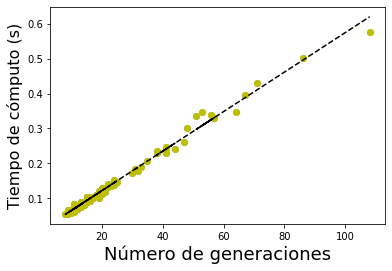

In [10]:
logger.setLevel(logging.WARNING)
import numpy as np
import matplotlib.pyplot as plt

def graficar_df(df:pd.DataFrame):
    x = df["Generations"]
    y = df["Compute_time"]

    plt.scatter(x, y, alpha=0.5)
    plt.xlabel('Número de generaciones', fontsize=18)
    plt.ylabel('Tiempo de cómputo (s)', fontsize=16)


    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y

    plt.plot(x,y,'yo',x,poly1d_fn(x),'--k')
graficar_df(df)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de mutación

In [11]:
logger.setLevel(logging.WARNING)
datos_mutacion_alta=[generaciones_y_tiempo(prob_mutación=0.3,max_iter=4000) for i in range(100)]


In [12]:
df2=limpiar_dataframe(datos_mutacion_alta)
df2.head()

,Generations,Compute_time
0,7,0.015019
1,8,0.017964
2,9,0.018149
3,7,0.018435
4,9,0.019948


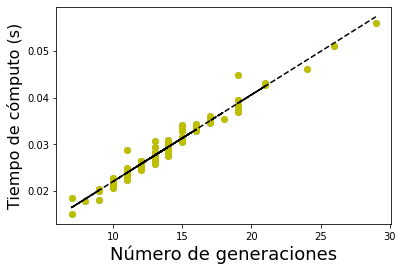

In [13]:
graficar_df(df2)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de cruza

In [14]:
datos=[generaciones_y_tiempo(prob_cruza=1,max_iter=4000) for i in range(100)]
df3=limpiar_dataframe(datos)
df3.head()

,Generations,Compute_time
0,8,0.016865
1,8,0.016987
2,8,0.017195
3,8,0.017449
4,8,0.017498


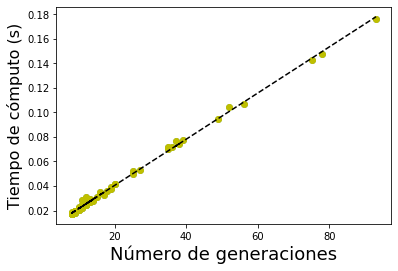

In [15]:
graficar_df(df3)

# En general es interesante ver como los parámetros afectan de distinta manera el tiempo de cómputo, o el número de generaciones que se necesita para llegar a una solución

In [16]:
toolbox.register("select", tools.selRoulette,fit_attr='fitness')

# Aleatoridad y tiempo de cómputo - Ruleta
A continuación veremos como el número de generaciones es proporcional al tiempo de cómputo. El resultado es bastante intuitivo, entre más generaciones tardamos en llegar a la lista de 1s, mayor es el tiempo de procesamiento


In [17]:
# Funcion para almacenar el número de generaciones y el tiempo de ejecución
import io
from contextlib import redirect_stdout


def generaciones_y_tiempo(
    poblacion_inicial: int = 50,
    tamaño_individuo: int = 30,
    prob_cruza: float = 0.7,
    prob_mutación: float = 0.0555,
    max_iter: int =1000):
    f = io.StringIO()
    with redirect_stdout(f):
        print(
            timeit.timeit(
                f"print(main(poblacion_inicial={poblacion_inicial} ,tamaño_individuo={tamaño_individuo} ,prob_cruza={prob_cruza},prob_mutación={prob_mutación},max_iter={max_iter}))",
                number=1,
                globals=globals(),
            )
        )
    out = f.getvalue()
    return list(out.split("\n")[:-1])


In [18]:
datos_tarea=[generaciones_y_tiempo() for i in range(100)]

In [19]:
import pandas as pd
def limpiar_dataframe(datos:list):
    df = pd.DataFrame(datos)
    df.rename(columns={0:"Generations",1:"Compute_time"},inplace=True)
    df=df.sort_values(by="Compute_time")
    df=df.reset_index(drop=True)
    df=df.astype({"Compute_time":float, "Generations":int})
    return df
df=limpiar_dataframe(datos_tarea)
df.head()

,Generations,Compute_time
0,25,0.065375
1,34,0.089969
2,40,0.103008
3,50,0.124837
4,49,0.125376


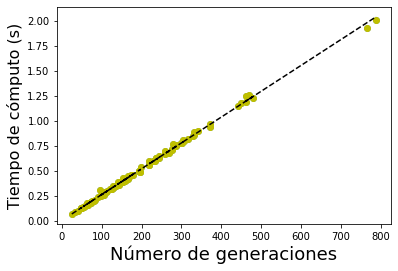

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def graficar_df(df:pd.DataFrame):
    x = df["Generations"]
    y = df["Compute_time"]

    plt.scatter(x, y, alpha=0.5)
    plt.xlabel('Número de generaciones', fontsize=18)
    plt.ylabel('Tiempo de cómputo (s)', fontsize=16)


    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y

    plt.plot(x,y,'yo',x,poly1d_fn(x),'--k')
graficar_df(df)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de mutación

In [21]:
datos_mutacion_alta=[generaciones_y_tiempo(prob_mutación=0.3,max_iter=4000) for i in range(100)]


In [22]:
df2=limpiar_dataframe(datos_mutacion_alta)
df2.head()

,Generations,Compute_time
0,46,0.120777
1,52,0.139460
2,57,0.149517
3,86,0.227402
4,93,0.265944


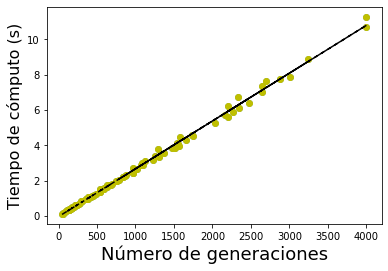

In [23]:
graficar_df(df2)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de cruza

In [24]:
datos=[generaciones_y_tiempo(prob_cruza=1,max_iter=4000) for i in range(100)]
df3=limpiar_dataframe(datos)
df3.head()

,Generations,Compute_time
0,35,0.088435
1,37,0.098509
2,44,0.113801
3,46,0.125115
4,48,0.130134


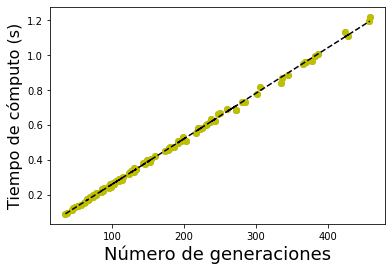

In [25]:
graficar_df(df3)